# Image Captioning using Word Embeddings and LSTM Networks

## Initialization

In [1]:
# Install required libraries
!pip install -qU openimages torch_snippets urllib3 nltk torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 816.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 3.4 MB/s et

In [2]:
# Import libraries
import json
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet152
from torchvision import transforms as T
from torch_snippets import *
import torchsummary as summary

from openimages.download import _download_images_by_id
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Sat Apr 20 20:00:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Download the dataset's information json file
!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl

# Load the json file and shuffle the data
with open('open_images_train_captions.jsonl', 'r') as json_file:
    json_list = json_file.read().split('\n')
np.random.shuffle(json_list)

# Loop through the files and fetch 100,000 images and their captions
data = []
total = 100_000
for idx, json_str in Tqdm(enumerate(json_list), total):
    if idx == total: break
    try:
        data.append(pd.DataFrame.from_dict(json.loads(json_str), orient='index').T)
    except:
        pass

100%|██████████| 100000/100000 [00:53<00:00, 1859.52it/s]


In [5]:
# Split the data into training and validation sets with 95% and 5% respectively
np.random.seed(10)
data = pd.concat(data)
data['train'] = np.random.choice([True, False], size=len(data), p=[0.95, 0.05])
data.head()

# Save the data to a csv file and load it
data.to_csv('data.csv', index=False)
data = pd.read_csv('data.csv')

In [6]:
# Download the images from the dataset
!mkdir -p train-images val-images
subset_image_ids = data[data['train']].image_id.tolist()
_download_images_by_id(subset_image_ids, 'train', './train-images/')

subset_image_ids = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_image_ids, 'train', './val-images/')

100%|██████████| 4956/4956 [01:55<00:00, 42.95it/s]


In [7]:
# Create a vocabulary for all the unique words in the captions
nltk.download('punkt')
all_captions = data[data['train']]['caption'].tolist()
all_tokens = [word_tokenize(c.lower()) for c in all_captions]

# Flatten the list of tokens
all_tokens = [w for sublist in all_tokens for w in sublist]

# Build vocabulary
vocab = defaultdict(lambda: len(vocab))
vocab['<pad>'] = 0  # Padding token
vocab['<unk>'] = 1  # Unknown token
vocab['<start>'] = 2  # Start token
vocab['<end>'] = 3  # End token
for token in all_tokens:
    vocab[token]

# Convert vocabulary to lists of words and indices (add extra padding token to the beginning)
itos = ['<pad>'] + sorted(vocab, key=vocab.get)

# Build stoi (string to index) dictionary
stoi = defaultdict(lambda: vocab['<unk>']) | {
    word: idx for idx, word in enumerate(itos)
}

# Build itos (index to string) dictionary
itos = dict(enumerate(itos))

# Display vocabulary
print("Vocabulary:")
print(itos)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Vocabulary:

{
    0: '<pad>',
    1: '<pad>',
    2: '<unk>',
    3: '<start>',
    4: '<end>',
    5: 'in',
    6: 'this',
    7: 'image',
    8: 'there',
    9: 'are',
    10: 'many',
    11: 'elephants',
    12: '.',
    13: 'on',
    14: 'the',
    15: 'right',
    16: 'is',
    17: 'a',
    18: 'building',
    19: 'ground',
    20: 'stones',
    21: 'background',
    22: 'trees',
    23: 'as',
    24: 'we',
    25: 'can',
    26: 'see',
    27: 'wall',
    28: ',',
    29: 'screen',
    30: 'windows',
    31: 'lights',
    32: 'few',
    33: 'people',
    34: 'here',
    35: 'and',
    36: 'tables',
    37: 'table',
    38: 'candle',
    39: 'plate',
    40: 'glass',
    41: 'fruits',
    42: 'board',
    43: 'attached',
    44: 'to',
    45: 'pole',
    46: 'plants',
    47: 'pavement',
    48: 'vehicles',
    49: 'road',
    50: 'connected',
    51: 'with',
    52: 'wires',
    53: 'buildings',
    54: 'top',
    55: 'of',
    56: 'sky',
    57: 'side',
    58: 'mannequin',
    59: 'behind',
    60: 'i',
    61: 'group',
    62: 'different',
    63: 'color',
    64: 'dresses',
    65: 'two',
    66: 'holding',
    67: 'sticks',
    68: 'these',
    69: 'boards',
    70: 'it',
    71: 'picture',
    72: 'women',
    73: 'standing',
    74: 'person',
    75: 'left',
    76: 'wearing',
    77: 'blue',
    78: 'uniform',
    79: 'cap',
    80: 'hand',
    81: 'bag',
    82: 'queue',
    83: 'painting',
    84: 'front',
    85: 'running',
    86: 'snow',
    87: 'some',
    88: 'text',
    89: 'woman',
    90: 'sitting',
    91: 'chair',
    92: 'objects',
    93: 'papers',
    94: 'books',
    95: 'bottles',
    96: 'bed',
    97: 'notice',
    98: 'bus',
    99: 'inside',
    100: 'visible',
    101: 'clock',
    102: 'tower',
    103: 'also',
    104: 'clouds',
    105: 'bottom',
    106: 'corner',
    107: 'compound',
    108: 'from',
    109: 'squat',
    110: 'position',
    111: 'camera',
    112: 'poles',
    113: 'black',
    114: 'white',
    115: 'goggles',
    116: 'reflection',
    117: 'clicking',
    118: 'beside',
    119: 'floor',
    120: 'blurred',
    121: 'ships',
    122: 'water',
    123: 'mountains',
    124: 'at',
    125: 'observe',
    126: 'food',
    127: 'places',
    128: 'placed',
    129: 'knife',
    130: 'bottle',
    131: 'something',
    132: 'led-headlight',
    133: 'rocks',
    134: 'hot',
    135: 'air',
    136: 'balloons',
    137: 'red',
    138: 'green',
    139: 'which',
    140: 'persons',
    141: 'one',
    142: 'spectacles',
    143: 't',
    144: 'shirt',
    145: 'train',
    146: 'has',
    147: 'written',
    148: 'track',
    149: 'vehicle',
    150: 'dog',
    151: 'houses',
    152: 'clear',
    153: 'railings',
    154: 'house',
    155: 'man',
    156: 'walking',
    157: 'walkway',
    158: 'podium',
    159: 'logo',
    160: 'microphone',
    161: 'stands',
    162: 'an',
    163: 'iron',
    164: 'rod',
    165: 'pillar',
    166: 'near',
    167: 'path',
    168: 'hens',
    169: 'does',
    170: "n't",
    171: 'have',
    172: 'hairs',
    173: 'helmets',
    174: 'trolley',
    175: 'boxes',
    176: 'be',
    177: 'seen',
    178: 'rope',
    179: 'mountain',
    180: 'brown',
    181: 'cream',
    182: 'flag',
    183: 'foreground',
    184: 'compact',
    185: 'disc',
    186: 'cartoon',
    187: 'that',
    188: 'cd',
    189: 'another',
    190: 'language',
    191: 'orange',
    192: 'either',
    193: 'paintings',
    194: 'railing',
    195: 'poster',
    196: 'dress',
    197: 'lamp',
    198: 'curtains',
    199: 'television',
    200: 'a.',
    201: 'mirror',
    202: 'light',
    203: '2',
    204: 'men',
    205: 'back',
    206: 'chandelier',
    207: 'large',
    208: 'body',
    209: 'grass',
    210: 'looks',
    211: 'cloudy',
    212: 'dancing',
    213: 'frame',
    214: "'s",
    215: 'consists',
    216: 'animal',
    217: 'center',
    218: 'doors',
    219: 'window',
    220: 'sides',
    221: 'walls',
    222: 'he',
    223: 'backpack',
    224: '

In [8]:
# Create Dataset class to fetch images and captions
class CaptioningData(Dataset):
    def __init__(self, root, df, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab
        self.transform = T.Compose([
            T.Resize(224),
            T.RandomCrop(224),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
        )

    def __getitem__(self, idx):
        row = self.df.iloc[idx].squeeze()
        image_path = f'{self.root}/{row["image_id"]}.jpg'
        image = Image.open(os.path.join(image_path)).convert('RGB')
        caption = row['caption']
        tokens = str(caption).lower().split()
        target = [
            stoi['<start>'],
            *[stoi[token] for token in tokens],
            stoi['<end>'],
        ]
        target = torch.Tensor(target).long()
        return image, caption, target

    def choose(self):
        return self[np.random.randint(len(self))]

    def __len__(self):
        return len(self.df)

    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, captions, targets = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for idx, tar in enumerate(targets):
            end = lengths[idx]
            _targets[idx, :end] = tar[:end]
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)

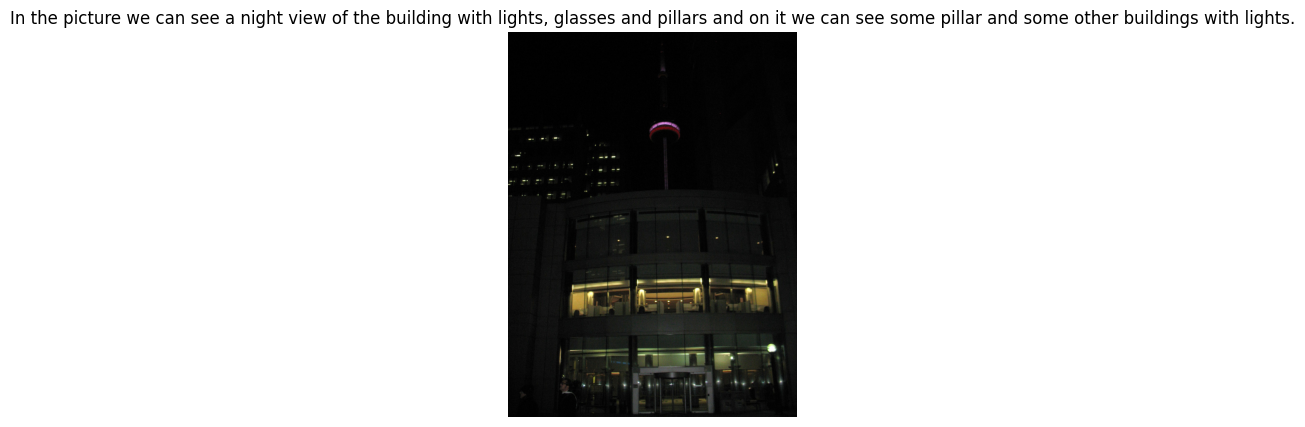

tensor([  3,   5,  14,  71,  24,  25,  26,  17, 275, 293,  55,  14,  18,  51,
          1, 230,  35, 732,  35,  13,  70,  24,  25,  26,  87, 165,  35,  87,
        407,  53,  51,   1,   4])

In [9]:
# Create train and validation datasets
train_ds = CaptioningData('train-images', data[data['train']], vocab)
val_ds = CaptioningData('val-images', data[~data['train']], vocab)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 32):
    train_dl = DataLoader(train_ds, batch_size, collate_fn=train_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size, collate_fn=val_ds.collate_fn)
    return train_dl, val_dl

# Display a sample image and caption
image, caption, target = train_ds.choose()
show(image, title=caption, sz=5)
print(target)

In [10]:
# Create a class for the Encoder CNN model
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = resnet152(weights='IMAGENET1K_V1')
        modules = list(resnet.children())[:-1] # Delete the last FC layer
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

# Create a mock-up model and print summary
encoder = EncoderCNN(256).to(device)
summary.summary(encoder, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 87.9MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
# Create a class for the Decoder RNN model
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        # Sort lengths array in decreasing order
        sorted_lengths, sorted_idx = torch.sort(lengths, descending=True)
        embeddings = embeddings[sorted_idx]

        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs

    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for _ in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)     # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))       # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1)                   # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                  # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                    # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)           # sampled_ids: (batch_size, max_seq_length)

        # Convert predicted tokens to strings
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []
            for word_id in sampled_id:
                word = itos[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
        return sentences

In [12]:
# Create a function to train the model on a batch of data
def train_batch(models, data, criterion, optimizer):
    encoder, decoder = models
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    sorted_lengths, sorted_idx = torch.sort(lengths, descending=True) # Convert lengths to PyTorch tensor and sort it in descending order
    captions = captions[sorted_idx]
    images = images[sorted_idx]  # Sort the images according to sorted indices
    sorted_lengths_cpu = sorted_lengths.cpu().long() # Move sorted_lengths tensor to CPU for pack_padded_sequence
    targets = pack_padded_sequence(captions, sorted_lengths_cpu, batch_first=True, enforce_sorted=False)[0]
    features = encoder(images)
    outputs = decoder(features, captions, sorted_lengths_cpu)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(models, data, criterion):
    encoder, decoder = models
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    sorted_lengths, sorted_idx = torch.sort(lengths, descending=True) # Sort the captions and images by lengths in descending order
    captions = captions[sorted_idx]
    images = images[sorted_idx]
    sorted_lengths_cpu = sorted_lengths.cpu().long() # Move sorted_lengths tensor to CPU for pack_padded_sequence
    targets = pack_padded_sequence(captions, sorted_lengths_cpu, batch_first=True, enforce_sorted=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, sorted_lengths_cpu)
    loss = criterion(outputs, targets)
    return loss

EPOCH: 1.000  train_loss: 1.940  val_loss: 1.826  (2498.92s - 22490.24s remaining)
EPOCH: 2.000  train_loss: 1.586  val_loss: 1.719  (5021.33s - 20085.32s remaining)
EPOCH: 3.000  train_loss: 1.467  val_loss: 1.676  (7535.11s - 17581.91s remaining)
EPOCH: 4.000  train_loss: 1.389  val_loss: 1.662  (10069.05s - 15103.58s remaining)
EPOCH: 5.000  train_loss: 1.332  val_loss: 1.659  (12595.03s - 12595.03s remaining)
EPOCH: 6.000  train_loss: 1.286  val_loss: 1.663  (15129.22s - 10086.14s remaining)
EPOCH: 7.000  train_loss: 1.210  val_loss: 1.632  (17658.59s - 7567.97s remaining)
EPOCH: 8.000  train_loss: 1.188  val_loss: 1.631  (20226.31s - 5056.58s remaining)
EPOCH: 9.000  train_loss: 1.176  val_loss: 1.631  (22802.52s - 2533.61s remaining)
EPOCH: 10.000  train_loss: 1.167  val_loss: 1.632  (25405.12s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 132.12it/s]


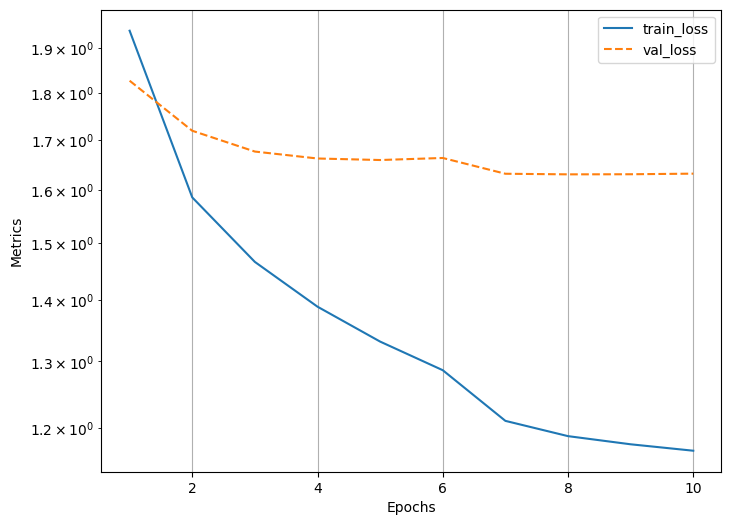

In [13]:
# Train the model
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(itos), 1).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
train_dl, val_dl = load_data()
n_epochs = 10

log = Report(n_epochs)
for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        train_loss = train_batch((encoder, decoder), data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=train_loss, end='\r')

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss = validate_batch((encoder, decoder), data, criterion)
        log.record(epoch+(i+1)/n, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

    if epoch == 5:
        optimizer = torch.optim.AdamW(params, lr=1e-4)

log.plot_epochs(log=True)

In [19]:
# Create a function to load an image for prediction
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image

# Create a function to make a prediction on an image
@torch.no_grad()
def load_image_and_predict(image_path):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    show(org_image, title=sentence, sz=10)
    return sentence

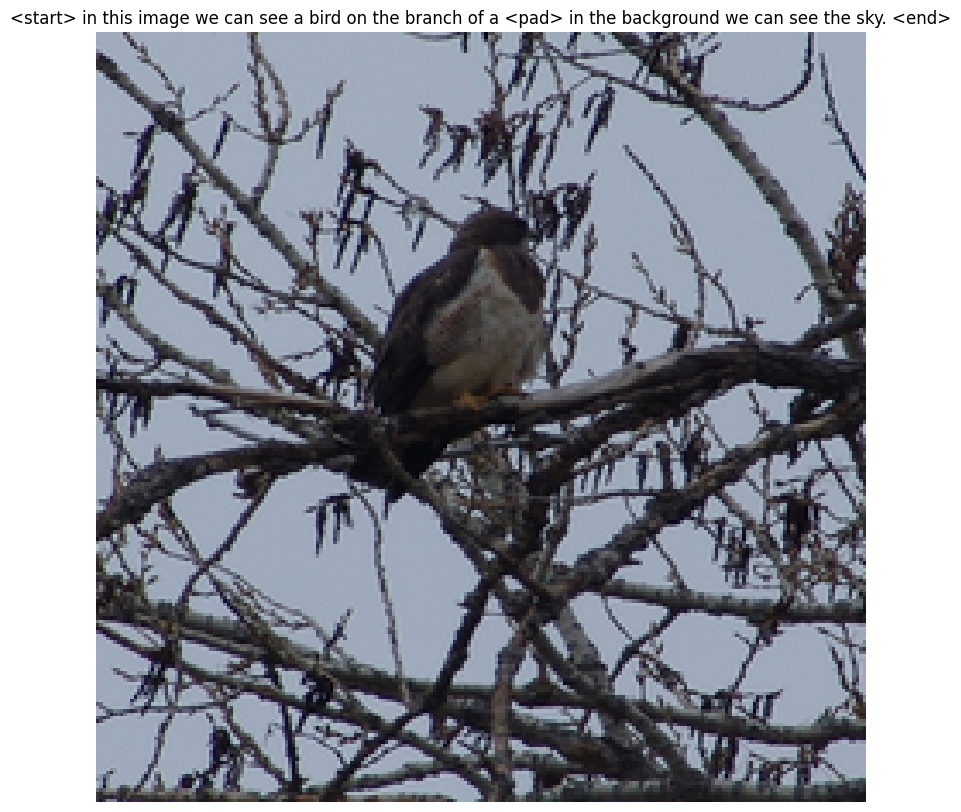

'<start> in this image we can see a bird on the branch of a <pad> in the background we can see the sky. <end>'

In [129]:
# Make predictions for 5 random images from the validation set
files = Glob('val-images')
load_image_and_predict(choose(files))